In [176]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from sklearn.metrics import classification_report, confusion_matrix

In [177]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

In [178]:
def class_size(path):
    for i in os.listdir(path):
        print(f'the {i} group has {len(os.listdir(os.path.join(path, i)))} images in the {path.split("/")[-1]} dataset\n')

In [179]:
class_size(train_dir)
class_size(val_dir)
class_size(test_dir)

the PNEUMONIA group has 3875 images in the train dataset

the NORMAL group has 1341 images in the train dataset

the PNEUMONIA group has 8 images in the val dataset

the NORMAL group has 8 images in the val dataset

the PNEUMONIA group has 390 images in the test dataset

the NORMAL group has 234 images in the test dataset



In [180]:
def plot_class_distribution(path):
    L = []
    for i in os.listdir(path):
        L.append((i, len(os.listdir(os.path.join(path, i)))))
    df = pd.DataFrame(L)
    df.columns = ['classes', 'count']

    color = ['#' + ''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for i in range(df['classes'].nunique())]
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    sns.barplot(data=df, x='classes', y='count',palette=color ,ax=axes[0])
    for i in axes[0].containers:
        axes[0].bar_label(i)
    axes[0].set_xlabel('')
    for l in axes[0].get_xticklabels():
        l.set_fontsize(10)
        l.set_weight('semibold')

    paches, text, pts = axes[1].pie(df['count'], 
                                    labels=df['classes'],
                                    autopct='%1.2f%%', 
                                    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
                                    textprops={'size': 'x-large'}, colors=color)

    for i in text:
        i.set_fontsize(10)
        i.set_weight('semibold')
    for num, i in enumerate(paches):
        text[num].set_color(i.get_facecolor())
    for i in pts:
        i.set_fontsize(10)

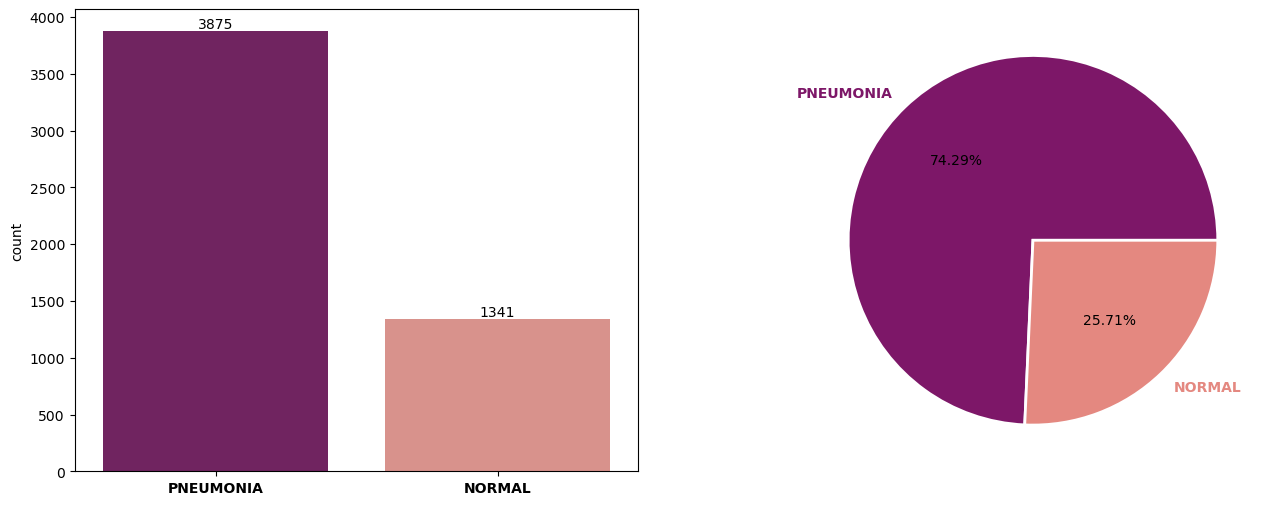

In [181]:
plot_class_distribution(train_dir)

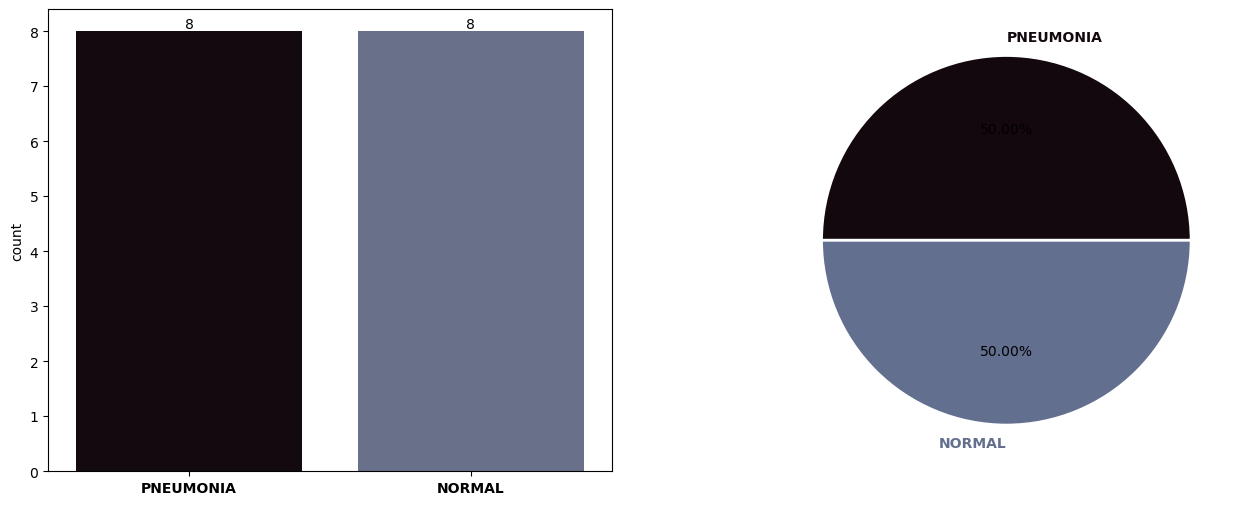

In [182]:
plot_class_distribution(val_dir)

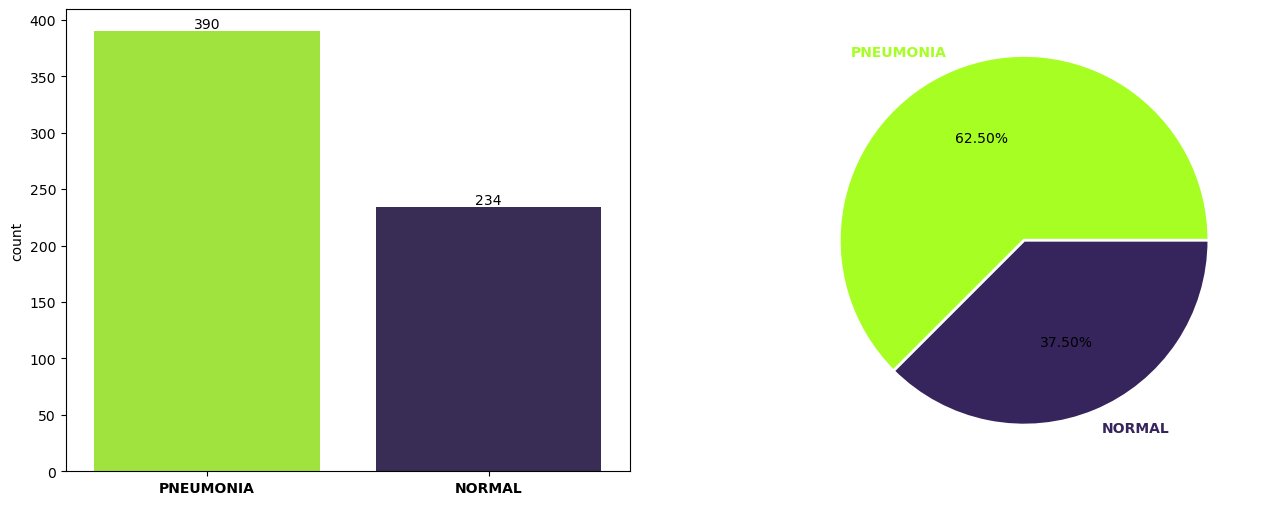

In [183]:
plot_class_distribution(test_dir)

### take a look at the sample pictures

In [184]:
def get_sample_images(path):
    for i in os.listdir(path):
        imgs = os.listdir(os.path.join(path, i))
        sample = random.sample(imgs, 6)
        fig, axes = plt.subplots(1,6, figsize=(20,4))
        for num, ax in enumerate(axes.flat):
            ax.imshow(plt.imread(os.path.join(path, i, sample[num])), cmap='gray')
            ax.set_title(i)
            ax.axis('off')

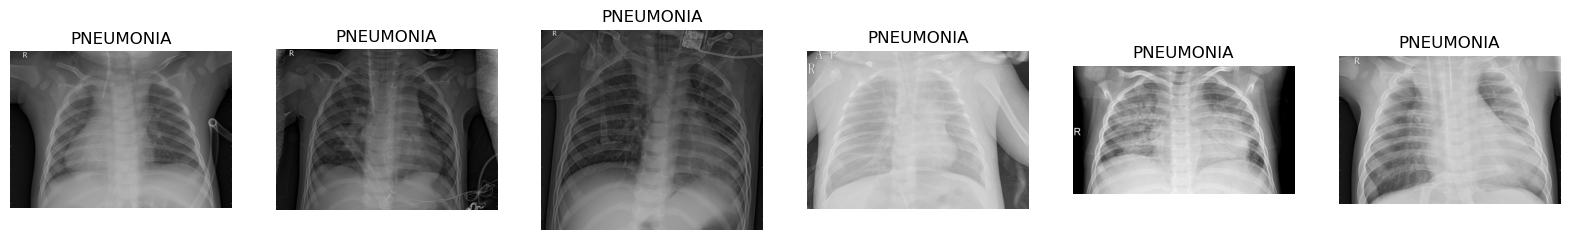

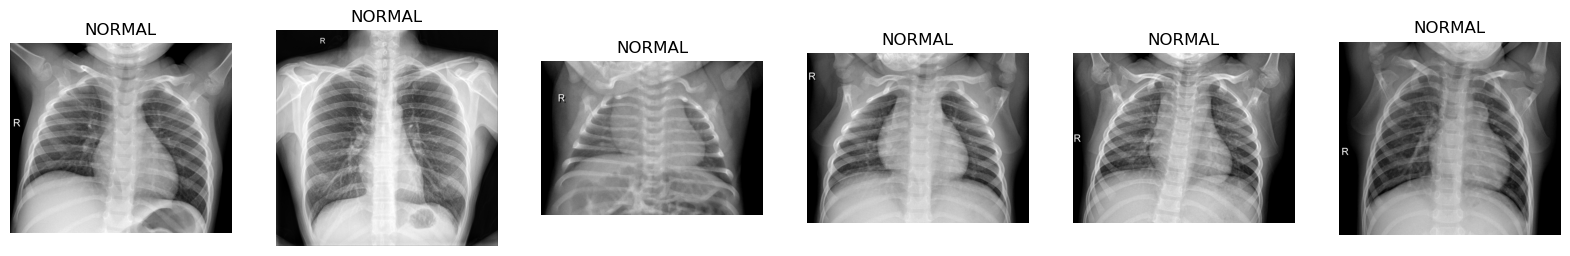

In [185]:
get_sample_images(train_dir)

### build the model

In [186]:
train_generator = ImageDataGenerator(rescale=1.0 / 255,
                                    horizontal_flip=True, 
                                    zoom_range=0.1, 
                                    shear_range=0.2, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1, 
                                    rotation_range=4, 
                                    vertical_flip=False)

val_generator = ImageDataGenerator(rescale=1.0 / 255)

test_generator = ImageDataGenerator(rescale=1.0 / 255)

In [174]:
train_data = train_generator.flow_from_directory(train_dir,
                                                    class_mode = 'categorical',
                                                    target_size = (48,48),
                                                    batch_size = 64,
                                                    shuffle = True)

val_data = val_generator.flow_from_directory(val_dir,
                                                class_mode = 'categorical',
                                                target_size = (48,48),
                                                batch_size = 64,
                                                shuffle = False)

test_data = val_generator.flow_from_directory(test_dir,
                                                class_mode = 'categorical',
                                                target_size = (48,48),
                                                batch_size = 64,
                                                shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [194]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_28 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 128)      

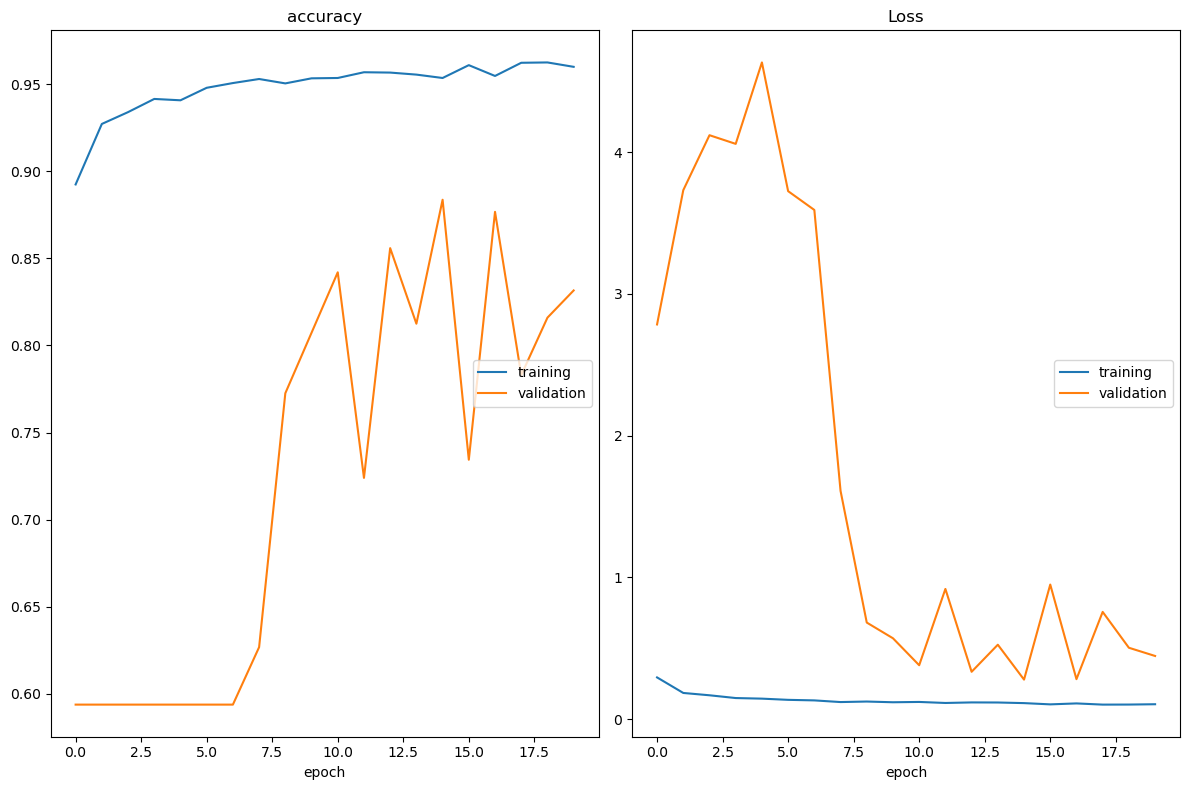

accuracy
	training         	 (min:    0.892, max:    0.963, cur:    0.960)
	validation       	 (min:    0.594, max:    0.884, cur:    0.832)
Loss
	training         	 (min:    0.103, max:    0.295, cur:    0.106)
	validation       	 (min:    0.279, max:    4.632, cur:    0.446)

Epoch 20: saving model to model_weights.h5
81/81 [==============================] - 86s 1s/step - loss: 0.1055 - accuracy: 0.9600 - val_loss: 0.4459 - val_accuracy: 0.8316 - lr: 3.1250e-05


In [195]:
epochs = 20
steps_per_epoch = train_data.n//64
validation_steps = test_data.n//64

checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy',save_weight_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, mode='auto')
callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x=train_data, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_data, 
                    validation_steps=validation_steps,
                    callbacks=callbacks)

### test the model

In [196]:
model.evaluate(test_data)

10/10 [==============================] - 6s 570ms/step - loss: 0.4153 - accuracy: 0.8429


[0.4152991473674774, 0.8429487347602844]

In [197]:
pred = model.predict(test_data, test_data.n//64)

10/10 [==============================] - 6s 562ms/step


<Axes: >

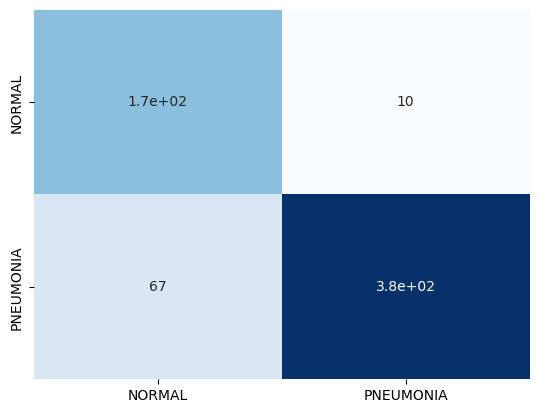

In [192]:
sns.heatmap(confusion_matrix(np.argmax(pred, axis=1), test_data.classes), annot=True, cmap='Blues', cbar=False, xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())

In [193]:
print(classification_report(np.argmax(pred, axis=1), test_data.classes))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       177
           1       0.97      0.85      0.91       447

    accuracy                           0.88       624
   macro avg       0.84      0.90      0.86       624
weighted avg       0.90      0.88      0.88       624



### save the model

In [198]:
model_json = model.to_json()
with open('model_json', 'w') as json_file:
    json_file.write(model_json)